In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../../AICity_data/train/S03/c010/'

In [3]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 514) # 514 is the 25% of the frames

100%|██████████| 513/513 [00:10<00:00, 49.53it/s]


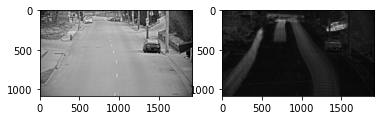

In [4]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(means, cmap='gray')
axs[1].imshow(stds, cmap='gray')

plt.show()

In [22]:
def cleanMask(mask, kernel_size=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size,kernel_size))
    # erosion_dst = cv2.erode(mask, element)
    # dilation = cv2.dilate(erosion_dst, element)
    # mask2 = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)
    # mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, element)
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)

def getBoxesFromMask(name, mask, kernel=5):
    cleaned = cleanMask(mask, kernel)
    cv2.imwrite(name, cleaned)
    output = cv2.connectedComponentsWithStats(np.uint8(cleaned), 8, cv2.CV_32S)
    (numLabels, labels, boxes, centroids) = output
    detectedElems = []
    for box in boxes[1:]: #First box is always the background
        if box[4] > 500: #Try to do a better estimation of the minimunm size
            # print(box)
            b = VehicleDetection(0, -1, float(box[0]), float(box[1]), float(box[2]), float(box[3]), float(-1))
            detectedElems.append(b)
            # tl = (int(b.xtl), int(b.ytl))
            # br = (int(b.xbr), int(b.ybr))
            # color = (255,0,0)
            # image = cv2.rectangle(image, tl, br, color, 2)
    return detectedElems

def remove_background(means, stds, videoPath, alpha=4, sigma=2, kernelMorph=5):
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            img_mask = np.zeros(img_gray.shape)
            img_mask[abs(img_gray - means) >= alpha * (stds + sigma)] = 255

            detections[str(frame)] = getBoxesFromMask(f'./masks/mask_{frame}.png',img_mask, kernelMorph)

    return detections


In [7]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

In [23]:
singleGaussianDetections = remove_background(means,stds, data_path + 'vdo.avi',3.8,2,7)

100%|██████████| 2141/2141 [02:35<00:00, 13.73it/s]


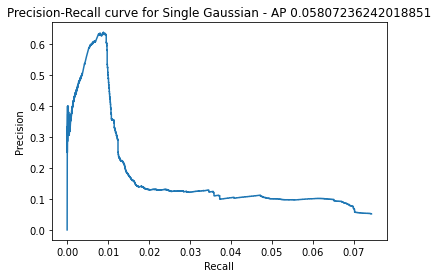

In [18]:
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for Single Gaussian - AP {ap}')

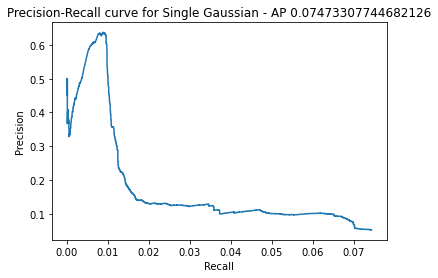

In [19]:
recs, precs, aps = ap_wo_conf(gt_detect,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Single Gaussian - AP {np.mean(aps)}')

In [56]:
alphas = np.linspace(2.0, 15, num=7, endpoint=False)
precs, recs, lables = [], [], []
for alpha in alphas:
    singleGaussianDetections = remove_background(means,stds, data_path + 'vdo.avi', alpha, 2, 7) #kernel for closing 7
    rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
    print(f'With Alpha {alpha} the AP is {ap}')
    lables.append(f'Alpha {alpha}')
    precs.append(prec)
    recs.append(rec)

plot_multiple_prec_recall_curves(precs, recs, lables, f'Precision-Recall curve for Single Gaussian - AP {ap}')

100%|██████████| 2141/2141 [02:57<00:00, 12.04it/s]


With Alpha 2.0 the AP is 0.045454545454545456


100%|██████████| 2141/2141 [03:01<00:00, 11.77it/s]


With Alpha 3.857142857142857 the AP is 0.06569001367675092


100%|██████████| 2141/2141 [03:03<00:00, 11.67it/s]


With Alpha 5.714285714285714 the AP is 0.047348484848484855


100%|██████████| 2141/2141 [02:55<00:00, 12.18it/s]


With Alpha 7.571428571428571 the AP is 0.045454545454545456


100%|██████████| 2141/2141 [02:57<00:00, 12.07it/s]


With Alpha 9.428571428571429 the AP is 0.04406950390329892


100%|██████████| 2141/2141 [03:02<00:00, 11.76it/s]


With Alpha 11.285714285714286 the AP is 0.051273985530040894


100%|██████████| 2141/2141 [03:01<00:00, 11.82it/s]


With Alpha 13.142857142857142 the AP is 0.052631578947368425


NameError: name 'labels' is not defined

100%|██████████| 2141/2141 [02:53<00:00, 12.35it/s]


With Alpha 2.0 the AP is 0.03598484848484848


100%|██████████| 2141/2141 [02:50<00:00, 12.58it/s]


With Alpha 3.4444444444444446 the AP is 0.061800765763319394


100%|██████████| 2141/2141 [02:48<00:00, 12.73it/s]


With Alpha 4.888888888888889 the AP is 0.046848856664807585


100%|██████████| 2141/2141 [02:44<00:00, 13.01it/s]


With Alpha 6.333333333333333 the AP is 0.04138155751058977


100%|██████████| 2141/2141 [02:39<00:00, 13.42it/s]


With Alpha 7.777777777777778 the AP is 0.03741035084318666


100%|██████████| 2141/2141 [02:32<00:00, 14.05it/s]


With Alpha 9.222222222222221 the AP is 0.04298418972332016


100%|██████████| 2141/2141 [02:32<00:00, 14.06it/s]


With Alpha 10.666666666666666 the AP is 0.04600886917960089


100%|██████████| 2141/2141 [02:32<00:00, 14.00it/s]


With Alpha 12.11111111111111 the AP is 0.04635761589403974


100%|██████████| 2141/2141 [02:31<00:00, 14.12it/s]


With Alpha 13.555555555555555 the AP is 0.038428448523085745


100%|██████████| 2141/2141 [02:30<00:00, 14.21it/s]


With Alpha 15.0 the AP is 0.031292149986512


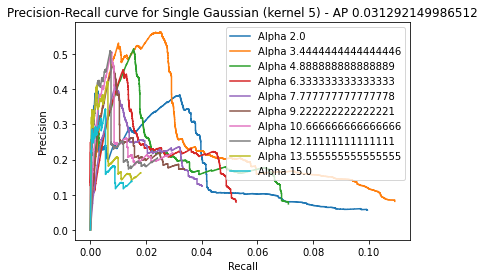

In [58]:
alphas = np.linspace(2.0, 15, num=10)
precs, recs, lables = [], [], []
for alpha in alphas:
    singleGaussianDetections = remove_background(means,stds, data_path + 'vdo.avi', alpha, 2, 5) #kernel for closing 5
    rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_detect, singleGaussianDetections, 0.5, False)
    print(f'With Alpha {alpha} the AP is {ap}')
    lables.append(f'Alpha {alpha}')
    precs.append(prec)
    recs.append(rec)

plot_multiple_prec_recall_curves(precs, recs, lables, f'Precision-Recall curve for Single Gaussian (kernel 5) - AP {ap}')

In [15]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, singleGaussianDetections, 'gaussDetectorAll', 514, 2100)

 98%|█████████▊| 2101/2141 [00:31<00:00, 67.39it/s]


frames 1587
